In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
df = pd.read_csv("cleaned_dataset.csv")
df = df[df["Midline_Shift_Label"] != 2]  
df = df.reset_index(drop=True)
print(f"Filtered dataset: {len(df)} samples")
print(df["Midline_Shift_Label"].value_counts())

Filtered dataset: 621 samples
Midline_Shift_Label
0    316
1    305
Name: count, dtype: int64


In [4]:
class BrainShiftDirectionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["processed_image_path"]
        label = int(self.df.iloc[idx]["Midline_Shift_Label"])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [5]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["Midline_Shift_Label"], random_state=42)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.RandomRotation(10),  # small rotation is fine
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

In [7]:
train_dataset = BrainShiftDirectionDataset(train_df, transform=train_transform)
val_dataset = BrainShiftDirectionDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [8]:
model = models.convnext_small(pretrained=True)
model.classifier[2] = nn.Linear(model.classifier[2].in_features, 2)  
model = model.to(device)

/Users/yaswanth/Downloads/SetProject/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/yaswanth/Downloads/SetProject/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)


In [10]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    scheduler.step()
    avg_loss = total_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 31/31 [00:29<00:00,  1.05it/s]


Epoch [1/10] - Train Loss: 0.6686


Epoch 2/10: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]


Epoch [2/10] - Train Loss: 0.1868


Epoch 3/10: 100%|██████████| 31/31 [00:24<00:00,  1.24it/s]


Epoch [3/10] - Train Loss: 0.0865


Epoch 4/10: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s]


Epoch [4/10] - Train Loss: 0.0805


Epoch 5/10: 100%|██████████| 31/31 [00:24<00:00,  1.27it/s]


Epoch [5/10] - Train Loss: 0.0593


Epoch 6/10: 100%|██████████| 31/31 [00:25<00:00,  1.24it/s]


Epoch [6/10] - Train Loss: 0.0244


Epoch 7/10: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s]


Epoch [7/10] - Train Loss: 0.0296


Epoch 8/10: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]


Epoch [8/10] - Train Loss: 0.0196


Epoch 9/10: 100%|██████████| 31/31 [00:25<00:00,  1.23it/s]


Epoch [9/10] - Train Loss: 0.0129


Epoch 10/10: 100%|██████████| 31/31 [00:24<00:00,  1.25it/s]

Epoch [10/10] - Train Loss: 0.0136


In [11]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


=== Evaluation Results (ConvNeXt-Small — Midline Direction) ===
Accuracy : 0.9760
Precision: 0.9677
Recall   : 0.9836
F1 Score : 0.9756

Classification Report:

              precision    recall  f1-score   support

        Left       0.98      0.97      0.98        64
       Right       0.97      0.98      0.98        61

    accuracy                           0.98       125
   macro avg       0.98      0.98      0.98       125
weighted avg       0.98      0.98      0.98       125



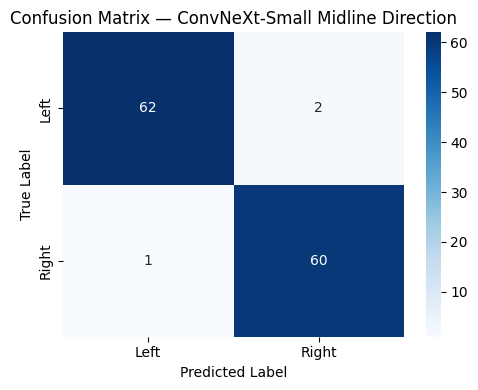

In [18]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\n=== Evaluation Results (ConvNeXt-Small — Midline Direction) ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Left", "Right"]))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Left", "Right"], yticklabels=["Left", "Right"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — ConvNeXt-Small Midline Direction")
plt.tight_layout()
plt.show()

In [19]:
torch.save(model.state_dict(), "midline_direction_convnext_small.pth")